In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
iris = load_iris()
x = iris['data']
y = iris['target'] 
print('訓練資料 : {}'.format(x.shape))
print('標籤 : {}'.format(np.unique(y)))

## 拆成訓練與測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

訓練資料 : (150, 4)
標籤 : [0 1 2]


### 判斷是否有GPU可以使用

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

pip install -U scikit-learn### 模型搭建

In [4]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [5]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 16)
        self.layer2 = LinearBNAC(16, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  
        

### 建立模型

* to(device) 代表轉成 cpu or gpu 模式 (gpu 模式下稱為 cuda)

In [6]:
model = Model(input_dimention=4,output_classes=3).to(device)

In [7]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 4])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([3, 32])
output.linear.bias torch.Size([3])


In [8]:
batch_size = 4
input_features = 4
dummy_input = torch.randn(batch_size, input_features).to(device)


In [9]:
output = model(dummy_input)
print(output)

tensor([[ 0.1921,  0.7305,  0.5264],
        [ 0.2942,  0.6647,  0.0222],
        [ 0.2481,  0.6746, -0.0258],
        [ 0.4565,  0.4620,  0.6997]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


## Loss

#### classification

In [10]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [11]:
## CrossEntropyLoss = LogSoftmax + NLLLoss

* CrossEntropyLoss

In [12]:
criterion = CrossEntropyLoss()

## optimizer

In [13]:
import torch.optim as optim

* params : iterable of parameters
* lr : learning rate
* weight_decay : (L2) Regularization (正則化) 

In [14]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

### 訓練前準備

In [15]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [16]:
batch_size = 4
epochs = 400
whole_batch = np.linspace(0, len(x_train), len(x_train)//batch_size+1).astype(np.uint8)[:-1]
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

In [17]:
whole_batch

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108], dtype=uint8)

### 訓練

In [18]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in whole_batch:
        x = x_train[batch : batch+batch_size,:]
        y = y_train[batch : batch+batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 50 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))


epoch : 0
目前 train loss : 1.18
目前 test loss : 1.00
目前 test accuracy : 0.68
epoch : 50
目前 train loss : 0.65
目前 test loss : 0.35
目前 test accuracy : 0.95
epoch : 100
目前 train loss : 0.55
目前 test loss : 0.32
目前 test accuracy : 0.92
epoch : 150
目前 train loss : 0.66
目前 test loss : 0.31
目前 test accuracy : 0.97
epoch : 200
目前 train loss : 0.52
目前 test loss : 0.30
目前 test accuracy : 0.97
epoch : 250
目前 train loss : 0.54
目前 test loss : 0.29
目前 test accuracy : 0.97
epoch : 300
目前 train loss : 0.50
目前 test loss : 0.28
目前 test accuracy : 0.95
epoch : 350
目前 train loss : 0.40
目前 test loss : 0.26
目前 test accuracy : 0.97


In [19]:
print(classification_report(prediction, y_test_numpy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.94      0.97        16
           2       0.92      1.00      0.96        11

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



In [20]:
test_loss_

[1.000214695930481,
 0.8949901461601257,
 0.8055332899093628,
 0.7253265976905823,
 0.7321918606758118,
 0.6756339073181152,
 0.6307017803192139,
 0.5657270550727844,
 0.5145283937454224,
 0.5480729937553406,
 0.5430552363395691,
 0.5318582057952881,
 0.5320023894309998,
 0.5365479588508606,
 0.423764169216156,
 0.46884462237358093,
 0.5002217292785645,
 0.4688480794429779,
 0.42682603001594543,
 0.47713014483451843,
 0.4675220549106598,
 0.4612196385860443,
 0.4138588607311249,
 0.4529453217983246,
 0.39141035079956055,
 0.39619114995002747,
 0.40925970673561096,
 0.4033237099647522,
 0.3854587972164154,
 0.4006079137325287,
 0.4324541985988617,
 0.3924792408943176,
 0.3908998370170593,
 0.37595489621162415,
 0.363956481218338,
 0.40815797448158264,
 0.37875896692276,
 0.38518276810646057,
 0.3160701096057892,
 0.3572828471660614,
 0.37542924284935,
 0.40227010846138,
 0.36238089203834534,
 0.3794156312942505,
 0.3750012218952179,
 0.36700794100761414,
 0.35518693923950195,
 0.3775205

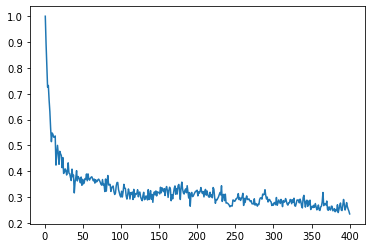

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

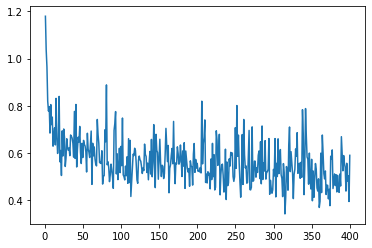

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

---

### 儲存跟載入 weight

### 儲存

In [24]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './model_save.pth' # './' 代表目前所屬路徑
torch.save(model.state_dict(), f=saving_location)

### 載入 

In [30]:
model = Model(input_dimention=4,output_classes=3).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
print('loading successfully...')

model.eval()
output = model(x_test)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()
test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
print(test_accuracy)

loading successfully...
0.9736842105263158


In [31]:
checkpoint

OrderedDict([('layer1.linear.0.weight',
              tensor([[ 0.1440, -0.4947,  0.1974, -0.4163],
                      [ 0.3862, -0.1545, -0.1720, -0.3875],
                      [-0.3607, -0.0200,  0.2233, -0.0077],
                      [-0.1524,  0.0594, -0.3236, -0.3783],
                      [-0.1001, -0.0892, -0.2485, -0.1446],
                      [-0.3786, -0.6062,  0.1753, -0.4097],
                      [-0.4990,  0.1246, -0.1847, -0.3521],
                      [-0.2458, -0.1937,  0.2085,  0.4271],
                      [ 0.2723, -0.1008,  0.5387, -0.3558],
                      [-0.1474,  0.3438,  0.3161,  0.5275],
                      [ 0.3248, -0.7679, -0.0257, -0.1192],
                      [ 0.3121,  0.0802,  0.5014,  0.2040],
                      [-0.0676, -0.4919,  0.3060,  0.1480],
                      [-0.2742, -0.0340, -0.5123,  0.1022],
                      [-0.2619,  0.0860,  0.0509,  0.5086],
                      [-0.1926, -0.5085,  0.2381, -0.1843]])

### 進階儲存
* 以字典的型式存入各種資料

In [32]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': loss_test,
            }, saving_location)

### 載入 

In [33]:
##載入訓練好的 weight

model = Model(input_dimention=4,output_classes=3).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
print('loading successfully...')
print('current loss : {}'.format(checkpoint['loss']))

model.eval()
output = model(x_test)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()
test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
print(test_accuracy)



loading successfully...
current loss : 0.2346932291984558
0.9736842105263158
